<h1>Data science Capstone project</h1>

<h2>1. Business understanding</h2>

<p>Suppose a pub chain: "Pin't" is planning to open a new pub in Dublin. We need to identify the neighbourhood which will likely be a success for the pub. The chain has several pubs in London. Each with a different ROI (Revenue on investment).</p>
<h5>Available data:</h5> 
    <li>Geolocation of existing pubs and potential neighbourhoods for new pub</li>
    <li>ROI of existing pubs</li>
<h5>Problem:</h5>
<p>
How can we identify a neighborhood, based on its location and the chain’s history and experience in other cities?</p>
<h5>Approach:</h5>
<p>Our approach is to use Foursquare location data and a clustering algorithm in order to cluster the potential neighbourhoods and the neighbourhoods where the chain has already established a pub, according to the category of venues close to each neighbourhood. And then choose the neighbourhood that belongs to the cluster with the most success rate. If there is a conflict: two potential neighbourhoods belong to most successful cluster we’ll be using other metrics: choose the neighbourhood with less pubs (for example)</p>
<h1>2. Data description:</h1>
<li>Categories of the venues in each neighbourhood venues (Foursquare API): It will help us group similar neighbourhoods based on the venues nearby.</li> 

<li>Existing pubs data: It will help us identify the most successful cluster based on existing pubs ROI. <a href="https://docs.google.com/spreadsheets/d/1UrTzTew7otS3l2AZS3aDeT2LqeLolHafxf1-3wIig08/edit?usp=sharing">https://docs.google.com/spreadsheets/d/1UrTzTew7otS3l2AZS3aDeT2LqeLolHafxf1-3wIig08/edit?usp=sharing</a></li>

<li>Potential neighbourhoods in Dublin: <a href="https://docs.google.com/spreadsheets/d/1QNCQQIdCHGsi6Re8IfioJaHm8ab5C11RQTGTXm-756M/edit?usp=sharing">https://docs.google.com/spreadsheets/d/1QNCQQIdCHGsi6Re8IfioJaHm8ab5C11RQTGTXm-756M/edit?usp=sharing</a></li>


<h3>2.1 Existing pubs data:</h3>

In [3]:
import numpy as  np# library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


In [4]:

import requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
london_pubs=pd.read_csv('existing_pubs.csv')
london_pubs.head()

,Neighbourhood,ROI
0,Barking and Dagenham,0.20
1,Barnet,0.76
2,Bexley,0.38
3,Brent,0.74
4,Bromley,0.29


In [5]:
def get_location(row,city):
    Borough=row['Neighbourhood']
    a=Borough+','+city
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(a)
    latitude = location.latitude
    longitude = location.longitude
    row['latitude']=latitude
    row['longitude']=longitude
    return row

In [6]:
london_pubs=london_pubs.apply(lambda row: get_location(row,'London'), axis=1)


In [38]:
london_pubs.head()

,Neighbourhood,ROI,latitude,longitude
0,Barking and Dagenham,0.20,51.554117,0.150504
1,Barnet,0.76,51.648784,-0.172913
2,Bexley,0.38,51.441679,0.150488
3,Brent,0.74,51.563826,-0.275760
4,Bromley,0.29,51.402805,0.014814


<h5><li>Visualizing existing pubs in London</li></h5>

In [7]:

address = 'London, England'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [8]:
from folium.features import DivIcon
map_london = folium.Map(location=[latitude,longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood,roi in zip(london_pubs['latitude'],london_pubs['longitude'], london_pubs['Neighbourhood']
                                      ,london_pubs['ROI']):
    label = '{}'.format(neighborhood)
    roi='{} '.format(roi)
    label = folium.Popup(label+roi, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        
        parse_html=True).add_to(map_london)  
map_london

<h5><li>Getting venues near existing pubs in London</li></h5>

In [12]:
CLIENT_ID = 'UT1GTTMAXJOA11RRWCSGYTF20AU1CHM4AQODWJLJVWLKNMWP' # your Foursquare ID
CLIENT_SECRET = 'EEAB2I5ARKJFIL4DAEJWIMBDR5XH1NRKD5DVFSTBHPG05KZ1' # your Foursquare Secret
VERSION = '20180605'
LIMIT=30
radius=5000
def explore(neighborhood_latitude, neighborhood_longitude):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    results = requests.get(url).json()
    return results

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        a = explore(lat,lng)["response"]
        
        results=a['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
venues_in_london = getNearbyVenues(names=london_pubs['Neighbourhood'],
                                   latitudes=london_pubs['latitude'],
                                   longitudes=london_pubs['longitude']
                                  )
venues_in_london.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.554117,0.150504,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.554117,0.150504,Harrow Lodge Park,51.555648,0.197926,Park
2,Barking and Dagenham,51.554117,0.150504,Capital Karts,51.531792,0.118739,Go Kart Track
3,Barking and Dagenham,51.554117,0.150504,The Eva Hart (Wetherspoon),51.570460,0.130342,Pub
4,Barking and Dagenham,51.554117,0.150504,Hylands Park,51.572074,0.191155,Park


In [15]:
venues_in_london.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Barking and Dagenham,30,30,30,30,30,30
Barnet,30,30,30,30,30,30
Bexley,30,30,30,30,30,30
Brent,30,30,30,30,30,30
Bromley,30,30,30,30,30,30
Camden,30,30,30,30,30,30
Croydon,30,30,30,30,30,30
Ealing,30,30,30,30,30,30
Enfield,30,30,30,30,30,30


In [16]:
london_onehot = pd.get_dummies(venues_in_london[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighbourhood'] = venues_in_london['Neighbourhood'] 
# move neighborhood column to the first column
index=london_onehot.columns.get_loc("Neighbourhood")
fixed_columns = [london_onehot.columns[index]] + list(london_onehot.columns[:index])+list(london_onehot.columns[index+1:])
london_onehot = london_onehot[fixed_columns]
london_onehot.head(3)


,Neighbourhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Caribbean Restaurant,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distillery,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hockey Field,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Noodle House,Observatory,Optical Shop,Outdoor Sculpture,Palace,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Restaurant,Rugby Stadium,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Shopping Plaza,Social Club,South Indian Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h5><li>Grouping the venues by neighborhoods and displaying the frequency of each category</li></h5>


In [19]:

london_grouped = london_onehot.groupby('Neighbourhood').mean().reset_index()
london_grouped

,Neighbourhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Caribbean Restaurant,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distillery,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hockey Field,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Noodle House,Observatory,Optical Shop,Outdoor Sculpture,Palace,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pizza Place,Planetarium,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Restaurant,Rugby Stadium,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Shopping Plaza,Social Club,South Indian Restaurant,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Barnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000

<h5><li>Sorting the venues near existing pubs in London</li></h5>

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = london_grouped['Neighbourhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Park,Coffee Shop,Italian Restaurant,Portuguese Restaurant,Furniture / Home Store,History Museum,Pet Store,Grocery Store,Pub,Multiplex
1,Barnet,Café,Park,Coffee Shop,Pub,Supermarket,Turkish Restaurant,Dessert Shop,Theater,Fish & Chips Shop,Plaza
2,Bexley,Park,Pub,Italian Restaurant,Café,American Restaurant,English Restaurant,Clothing Store,Grocery Store,Performing Arts Venue,Museum
3,Brent,Indian Restaurant,Clothing Store,Hotel,Latin American Restaurant,Portuguese Restaurant,Sporting Goods Shop,Café,Sandwich Place,Chinese Restaurant,Chocolate Shop
4,Bromley,Pub,Park,Coffee Shop,Pizza Place,Gym / Fitness Center,Indie Movie Theater,Fast Food Restaurant,Cocktail Bar,Portuguese Restaurant,Burger Joint


<h3>2.1 Potential pubs data:</h3>

In [20]:
potential_pubs=pd.read_csv('potential_pubs.csv')
potential_pubs

,Neighbourhood
0,St. Stephen’s Green
1,Temple Bar
2,Christchurch
3,Ranelagh and Rathmines
4,Ballsbridge and Donnybrook
5,Drumcondra
6,Malahide
7,Dalkey


In [21]:
potential_pubs=potential_pubs.apply(lambda row: get_location(row,'Dublin'), axis=1)

In [22]:
potential_pubs

,Neighbourhood,latitude,longitude
0,St. Stephen’s Green,53.337990,-6.259073
1,Temple Bar,53.345496,-6.263114
2,Christchurch,53.342689,-6.272784
3,Ranelagh and Rathmines,53.325218,-6.255050
4,Ballsbridge and Donnybrook,53.335711,-6.245229
5,Drumcondra,53.372525,-6.249515
6,Malahide,53.450840,-6.153670
7,Dalkey,53.275607,-6.103188


<h5><li>Visualizing potential pubs in Dublin</li></h5>

In [23]:

address = 'Dublin, Ireland'

geolocator = Nominatim(user_agent="ny_explorer")
d_location = geolocator.geocode(address)
d_latitude = d_location.latitude
d_longitude = d_location.longitude
print('The geograpical coordinate of Dublin are {}, {}.'.format(d_latitude, d_longitude))


The geograpical coordinate of Dublin are 53.3497645, -6.2602732.


In [24]:
map_dublin = folium.Map(location=[d_latitude,d_longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(potential_pubs['latitude'],potential_pubs['longitude'], potential_pubs['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  
    
map_dublin

<h5><li>Getting venues near potential pubs in Dublin</li></h5>

In [25]:
venues_in_dublin = getNearbyVenues(names=potential_pubs['Neighbourhood'],
                                   latitudes=potential_pubs['latitude'],
                                   longitudes=potential_pubs['longitude']
                                  )
venues_in_dublin.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Ballsbridge and Donnybrook,30,30,30,30,30,30
Christchurch,30,30,30,30,30,30
Dalkey,30,30,30,30,30,30
Drumcondra,30,30,30,30,30,30
Malahide,30,30,30,30,30,30
Ranelagh and Rathmines,30,30,30,30,30,30
St. Stephen’s Green,30,30,30,30,30,30
Temple Bar,30,30,30,30,30,30


In [45]:
venues_in_dublin.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. Stephen’s Green,53.33799,-6.259073,St Stephen's Green,53.338151,-6.259160,Park
1,St. Stephen’s Green,53.33799,-6.259073,Hatch & Sons,53.339515,-6.258460,Café
2,St. Stephen’s Green,53.33799,-6.259073,Dolce Sicily,53.340942,-6.258772,Café
3,St. Stephen’s Green,53.33799,-6.259073,Peruke & Periwig,53.340086,-6.258542,Cocktail Bar
4,St. Stephen’s Green,53.33799,-6.259073,Iveagh Gardens,53.335680,-6.261059,Park


In [26]:
dublin_onehot = pd.get_dummies(venues_in_dublin[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighbourhood'] = venues_in_dublin['Neighbourhood'] 
# move neighborhood column to the first column
index=dublin_onehot.columns.get_loc("Neighbourhood")
fixed_columns = [dublin_onehot.columns[index]] + list(dublin_onehot.columns[:index])+list(dublin_onehot.columns[index+1:])
dublin_onehot = dublin_onehot[fixed_columns]
dublin_onehot.head(3)



,Neighbourhood,American Restaurant,Art Museum,Bar,Beach,Beer Bar,Bistro,Bookstore,Botanical Garden,Burger Joint,Café,Canal,Castle,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Falafel Restaurant,Farmers Market,Fish & Chips Shop,Fish Market,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Historic Site,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Liquor Store,Lounge,Mexican Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Outdoor Sculpture,Park,Pizza Place,Plaza,Pub,Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Stadium,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,St. Stephen’s Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,St. Stephen’s Green,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,St. Stephen’s Green,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
dublin_grouped = dublin_onehot.groupby('Neighbourhood').mean().reset_index()
dublin_grouped

,Neighbourhood,American Restaurant,Art Museum,Bar,Beach,Beer Bar,Bistro,Bookstore,Botanical Garden,Burger Joint,Café,Canal,Castle,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Falafel Restaurant,Farmers Market,Fish & Chips Shop,Fish Market,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Historic Site,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Liquor Store,Lounge,Mexican Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Outdoor Sculpture,Park,Pizza Place,Plaza,Pub,Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Stadium,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Ballsbridge and Donnybrook,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.166667,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.100000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.066667,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.100000,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000
1,Christchurch,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.133333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000
2,Dalkey,0.000000,0.000000,0.033333,0.133333,0.000000,0.033333,0.000000,0.000000,0.000000,0.066667,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.066667,0.000000,0.066667,0.033333,0.066667,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Drumcondra,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.200000,0.000000,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.066667,0.033333,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Malahide,0.033333,0.000000,0.033333,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.033333,0.000000,0.000000,0

<h5><li>Sorting venues near potential pubs</li></h5>

In [28]:
# create a new dataframe
potential_neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
potential_neighbourhoods_venues_sorted['Neighbourhood'] = dublin_grouped['Neighbourhood']

for ind in np.arange(dublin_grouped.shape[0]):
    potential_neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

potential_neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballsbridge and Donnybrook,Café,Coffee Shop,Park,Hotel,Lounge,Concert Hall,Cocktail Bar,Outdoor Sculpture,Pizza Place,Plaza
1,Christchurch,Café,Pub,Coffee Shop,Music Venue,Park,Cocktail Bar,Restaurant,Ice Cream Shop,Irish Pub,Burger Joint
2,Dalkey,Beach,Coffee Shop,Scenic Lookout,Restaurant,Park,Pub,Café,Seafood Restaurant,Italian Restaurant,Farmers Market
3,Drumcondra,Coffee Shop,Café,Pub,Clothing Store,Restaurant,Hotel,Donut Shop,Discount Store,Italian Restaurant,Korean Restaurant
4,Malahide,Café,Italian Restaurant,Beach,American Restaurant,Pub,Gourmet Shop,Garden,Gym,Hotel,French Restaurant


<h2>3. Methodology</h2>
<p>In this part we'll work on our neighbourhoods data in order to cluster our neighbourhoods into similar groups based on the venues nearby. The potential neighbourhoods that belongs to the most successful cluster (cluster with highest mean of ROI or cluster where the neighbourhood with highest ROI belongs) will be the locations of our next pubs in Dublin </p>
<h5>3.1 Data exploration</h5>
<li>Correleation between ROI and distance from London Central (presented by The big ben)</li>

<p>Getting distance from big ben</p>

In [35]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0
def distance_big_ben(row):
    #big ben coordinates
    lat1 = radians(51.5007)
    lon1 = radians(0.1246)
    lat2 = radians(row['latitude'])
    lon2 = radians(row['longitude'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [36]:
london_pubs.loc[:,'distance from central London']=london_pubs.apply(lambda row:distance_big_ben(row),axis=1)
london_pubs.sort_values(by=['ROI'], ascending=False)

,Neighbourhood,ROI,latitude,longitude,distance from central London
10,Hackney,0.78,51.543240,-0.049362,12.936147
29,Waltham Forest,0.77,51.598169,-0.017837,14.649178
1,Barnet,0.76,51.648784,-0.172913,26.349405
21,Lewisham,0.75,51.462432,-0.010133,10.257794
19,Kingston upon Thames,0.74,51.409627,-0.306262,31.534463
3,Brent,0.74,51.563826,-0.275760,28.578105
23,Newham,0.72,51.530000,0.029318,7.356572
17,Islington,0.67,51.538429,-0.099905,16.095262
15,Hillingdon,0.64,51.542519,-0.448335,39.924256
27,Sutton,0.64,51.357511,-0.173640,26.104506


In [38]:
%%capture
! pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


In [42]:
london_pubs[['distance from central London','ROI']].corr()

,distance from central London,ROI
distance from central London,1.000000,0.045609
ROI,0.045609,1.000000


<p>The correlation between ROI and distance from central London is weak (0.045) as we can see in the plot, so there is no need to include it in our clustering criteria</p>

(0, 0.8117919339817881)

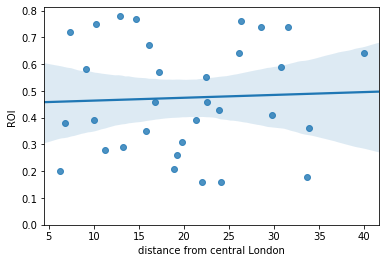

In [44]:
sns.regplot(x="distance from central London", y="ROI", data=london_pubs)
plt.ylim(0,)

<h5>Clustering the neighbourhoods</h5>

In [140]:
#merging neighbourhoods
all_neighbourhoods=pd.concat([london_grouped,dublin_grouped],sort=False,ignore_index=True)

In [213]:
all_venues=pd.concat([neighborhoods_venues_sorted,potential_neighbourhoods_venues_sorted],sort=False,ignore_index=True)

In [142]:
all_neighbourhoods.fillna(0,inplace=True)

<p>k-means clustering</p>

In [212]:
kclusters = 5

neighbourhoods_clustering = all_neighbourhoods.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbourhoods_clustering)

In [214]:
kmeans.labels_[0:10]

array([0, 3, 1, 2, 1, 2, 1, 1, 1, 1], dtype=int32)

In [215]:
all_venues.insert(0, 'Cluster Labels', kmeans.labels_)

In [216]:
all_venues.insert(0, 'ROI', london_pubs['ROI']) #getting ROI values from london pubs

In [217]:
all_venues.loc[32:,'ROI']=np.nan #setting ROI values to np.nan for Irish neighbourhoods to replace the values set and not be taken into consideration in mean

In [218]:
all_venues.groupby('Cluster Labels').mean() #Cluster 3 is the cluster with the highest mean of ROI

,ROI
Cluster Labels,
0,0.415000
1,0.475385
2,0.440000
3,0.610000
4,0.460000


<p>Let's examine the clusters</p>

In [ ]:
all_venues.loc[0:31,'City']='London' #adding the city to the neighbourhoods
all_venues.loc[32:,'City']='Dublin'

In [221]:
print(all_venues.loc[all_venues['Cluster Labels'] == 0,['ROI','City']].mean())
all_venues.loc[all_venues['Cluster Labels'] == 0,['ROI','City','Neighbourhood']]

ROI    0.415
dtype: float64


,ROI,City,Neighbourhood
0,0.20,London,Barking and Dagenham
16,0.36,London,Hounslow
27,0.64,London,Sutton
30,0.46,London,Wandsworth


In [222]:
print(all_venues.loc[all_venues['Cluster Labels'] == 1,['ROI','City']].mean())
all_venues.loc[all_venues['Cluster Labels'] == 1,['ROI','City','Neighbourhood']]

ROI    0.475385
dtype: float64


,ROI,City,Neighbourhood
2,0.38,London,Bexley
4,0.29,London,Bromley
6,0.39,London,Croydon
7,0.41,London,Ealing
8,0.16,London,Enfield
9,0.58,London,Greenwich
15,0.64,London,Hillingdon
19,0.74,London,Kingston upon Thames
22,0.43,London,Merton
23,0.72,London,Newham


In [223]:
print(all_venues.loc[all_venues['Cluster Labels'] == 2,['ROI','City']].mean())
all_venues.loc[all_venues['Cluster Labels'] == 2,['ROI','City','Neighbourhood']]


ROI    0.44
dtype: float64


,ROI,City,Neighbourhood
3,0.74,London,Brent
5,0.21,London,Camden
11,0.16,London,Hammersmith and Fulham
13,0.18,London,Harrow
14,0.26,London,Havering
17,0.67,London,Islington
18,0.55,London,Kensington and Chelsea
21,0.75,London,Lewisham


In [224]:
print(all_venues.loc[all_venues['Cluster Labels'] == 3,['ROI','City']].mean())
all_venues.loc[all_venues['Cluster Labels'] == 3,['ROI','City','Neighbourhood']]

ROI    0.61
dtype: float64


,ROI,City,Neighbourhood
1,0.76,London,Barnet
10,0.78,London,Hackney
12,0.31,London,Haringey
25,0.59,London,Richmond upon Thames
32,NaN,Dublin,Ballsbridge and Donnybrook
33,NaN,Dublin,Christchurch
34,NaN,Dublin,Dalkey
35,NaN,Dublin,Drumcondra
36,NaN,Dublin,Malahide
37,NaN,Dublin,Ranelagh and Rathmines


In [225]:
print(all_venues.loc[all_venues['Cluster Labels'] == 4,['ROI','City']].mean())
all_venues.loc[all_venues['Cluster Labels'] == 4,['ROI','City','Neighbourhood']]

ROI    0.46
dtype: float64


,ROI,City,Neighbourhood
20,0.46,London,Lambeth
26,0.35,London,Southwark
31,0.57,London,Westminster


In [226]:
print(all_venues.loc[all_venues['Cluster Labels'] == 5,['ROI','City']].mean())
all_venues.loc[all_venues['Cluster Labels'] == 5,['ROI','City','Neighbourhood']]

ROI    NaN
City   NaN
dtype: float64


,ROI,City,Neighbourhood


<p>Let's examine the potential neighbourhoods in cluster three: most successful cluster with an average of 0.61 ROI</p>

In [227]:
potential_pubs=all_venues.loc[(all_venues['Cluster Labels']== 3)]

In [228]:
potential_pubs.drop(columns=['City','Cluster Labels']).sort_values(by='ROI',ascending=False)

,ROI,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,0.78,Hackney,Coffee Shop,Café,Pub,Park,Indie Movie Theater,Market,Canal Lock,Butcher,Flea Market,Pool
1,0.76,Barnet,Café,Park,Coffee Shop,Pub,Supermarket,Turkish Restaurant,Dessert Shop,Theater,Fish & Chips Shop,Plaza
25,0.59,Richmond upon Thames,Park,Café,Garden,Coffee Shop,Hotel,Italian Restaurant,Bakery,Scenic Lookout,Pub,Liquor Store
12,0.31,Haringey,Café,Mediterranean Restaurant,Turkish Restaurant,Park,Coffee Shop,Pizza Place,Gourmet Shop,Garden Center,Indie Movie Theater,Indie Theater
32,NaN,Ballsbridge and Donnybrook,Café,Coffee Shop,Park,Hotel,Lounge,Concert Hall,Cocktail Bar,Outdoor Sculpture,Pizza Place,Plaza
33,NaN,Christchurch,Café,Pub,Coffee Shop,Music Venue,Park,Cocktail Bar,Restaurant,Ice Cream Shop,Irish Pub,Burger Joint
34,NaN,Dalkey,Beach,Coffee Shop,Scenic Lookout,Restaurant,Park,Pub,Café,Seafood Restaurant,Italian Restaurant,Farmers Market
35,NaN,Drumcondra,Coffee Shop,Café,Pub,Clothing Store,Restaurant,Hotel,Donut Shop,Discount Store,Italian Restaurant,Korean Restaurant
36,NaN,Malahide,Café,Italian Restaurant,Beach,American Restaurant,Pub,Gourmet Shop,Garden,Gym,Hotel,French Restaurant
37,NaN,Ranelagh and Rathmines,Café,Park,Coffee Shop,Restaurant,Hotel,Burger Joint,Chinese Restaurant,Falafel Restaurant,Pub,Sandwich Place


<h5>We notice that the 3 most common venues categories in the most succesful pubs in London are: Coffeshops, cafés apubs and parks</h5>
<p>=> In order to make a decision we need to choose the neighbourhood which 3 most common venues categories are in the list</p>
<p>The potential neighbourhoods that check the criteria are: </p>
<li>Ballsbridge and Donnybrook</li>
<li>Christchurch</li>
<li>Drumcondra</li>
<li>Ranelagh and Rathmines</li>
<p>To refine our choices we notice that <b>Ranelagh and Rathmines</b> is the most similar neighbourhood to Hackney where the most successful pub is established: with the same first 3 most common venues categories</p>